<a href="https://colab.research.google.com/github/lavneetjaneja/Object-detection/blob/master/obj_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5736 (delta 12), reused 14 (delta 5), pack-reused 5705
Receiving objects: 100% (5736/5736), 13.37 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (3843/3843), done.


In [0]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169029 sha256=4011267814b20b94f6aa5ead0327ffc05dcc1792b52d4a680a645a1762e1b73a
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=2c33f389481b2834ac417b2e949446bfc954cf140a36277fae42ac1b0d00198c
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [0]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [0]:
# https://www.kaggle.com/dataturks/face-detection-in-images
%cd ..
!wget -nc https://lazyprogrammer.me/course_files/face_detection.json

/content
--2020-05-22 18:41:39--  https://lazyprogrammer.me/course_files/face_detection.json
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273830 (267K) [application/json]
Saving to: ‘face_detection.json’

face_detection.json 100%[===================>] 267.41K   341KB/s    in 0.8s    

2020-05-22 18:41:40 (341 KB/s) - ‘face_detection.json’ saved [273830/273830]



In [0]:
!head face_detection.json

{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e00

In [0]:
import json
j = json.loads(open('face_detection.json').readline())
j

{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [0]:
df = pd.read_json('face_detection.json', lines=True)

In [0]:
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


In [0]:
df.shape

(409, 3)

In [0]:
r = requests.get('http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg')
with open('testimg.jpg', 'wb') as f:
  f.write(r.content)

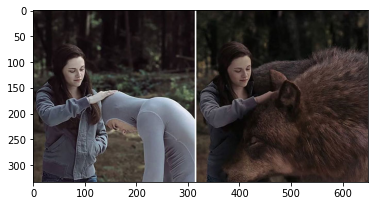

In [0]:
im = Image.open('testimg.jpg')
plt.imshow(im)

In [0]:
converted_data_train = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

converted_data_test = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

In [0]:
if not os.path.exists('faces'):
  os.mkdir('faces')

In [0]:
idx = 0 # global counter for filenames

def map_to_data(row, converted_data):
  global idx
  r = requests.get(row['content'])
  filepath = 'faces/face_%s.jpg' % idx

  # don't bother to overwrite
  if not os.path.exists(filepath):
    with open(filepath, 'wb') as f:
      f.write(r.content)

  # there could be more than 1 face per image
  for anno in row['annotation']:
    converted_data['image_name'].append(filepath)

    width = anno['imageWidth']
    height = anno['imageHeight']

    # calculate box coordinates
    x1 = int(round(anno['points'][0]['x'] * width))
    y1 = int(round(anno['points'][0]['y'] * height))
    x2 = int(round(anno['points'][1]['x'] * width))
    y2 = int(round(anno['points'][1]['y'] * height))

    converted_data['x_min'].append(x1)
    converted_data['y_min'].append(y1)
    converted_data['x_max'].append(x2)
    converted_data['y_max'].append(y2)

    # they are all the same class
    converted_data['class_name'].append('face')
  
  # update counter
  idx += 1

In [0]:
# we must split BEFORE converting the data
# after converting the data, multiple rows will have the same image
# we won't want to split then3
train_df, test_df = train_test_split(df, test_size=0.2)

In [0]:
# this will be slow since it has to download all the images

# just in case we run again later
idx = 0

# train
train_df.apply(lambda row: map_to_data(row, converted_data_train), axis=1)

# test
test_df.apply(lambda row: map_to_data(row, converted_data_test), axis=1)

158    None
373    None
125    None
319    None
107    None
       ... 
331    None
120    None
141    None
207    None
168    None
Length: 82, dtype: object

In [0]:
# this will overwrite the previous dfs
train_df = pd.DataFrame(converted_data_train)
test_df = pd.DataFrame(converted_data_test)
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_0.jpg,325,202,468,362,face
1,faces/face_0.jpg,197,415,336,544,face
2,faces/face_0.jpg,518,229,653,361,face
3,faces/face_0.jpg,685,191,826,345,face
4,faces/face_1.jpg,134,46,273,226,face


In [0]:
train_df.shape

(933, 6)

In [0]:
train_df[train_df['image_name'] == 'faces/face_3.jpg']

,image_name,x_min,y_min,x_max,y_max,class_name
9,faces/face_3.jpg,326,116,446,277,face
10,faces/face_3.jpg,841,87,955,285,face


In [0]:
def show_image_with_boxes(df):
  # pick a random image
  filepath = df.sample()['image_name'].values[0]

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()

[35, 24, 338, 336]
[290, 2, 490, 308]


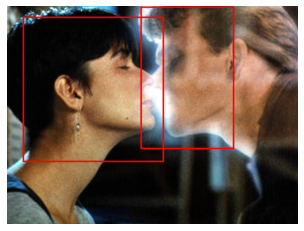

In [0]:
show_image_with_boxes(train_df)